In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def load_data(filepath):
    h5f = h5py.File(filepath, 'r')
    X_train = h5f['X_train'][:]
    y_train = h5f['y_train'][:]
    X_test = h5f['X_test'][:]
    y_test = h5f['y_test'][:]
    h5f.close()
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data('data/RockAI_224x224_testset50_images.h5')

num_classes = 2

#Pre-process the data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
# datagen = ImageDataGenerator()
datagen.fit(X_train)

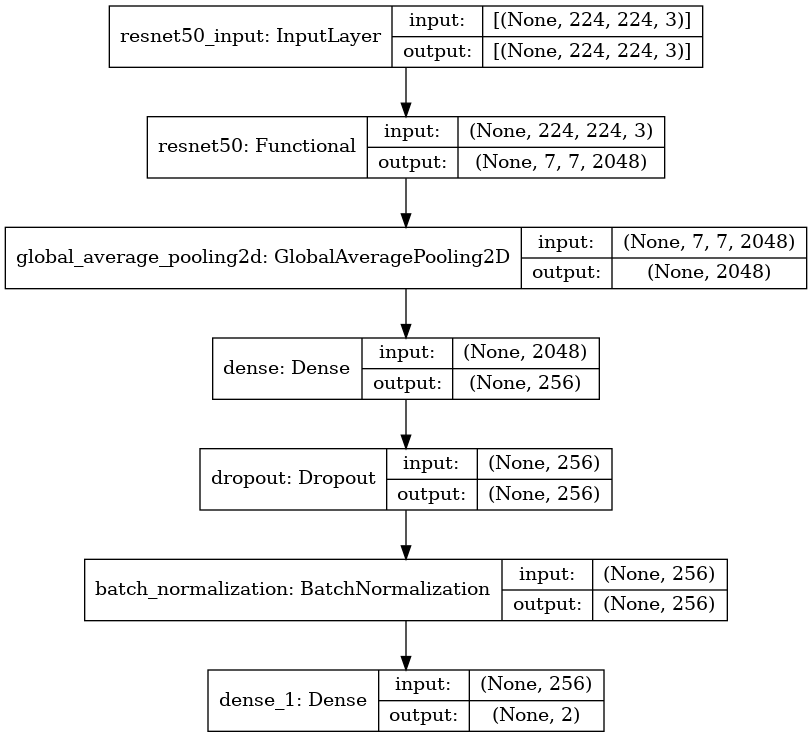

In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

tf.keras.utils.plot_model(model, show_shapes=True, to_file='outdir/resnet50_model.png')

In [6]:
batch_size = 32
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

historytemp = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=10)

Epoch 1/10
42/42 [==============================] - 10s 135ms/step - loss: 0.8466 - accuracy: 0.5852
Epoch 2/10
42/42 [==============================] - 5s 119ms/step - loss: 0.3454 - accuracy: 0.8732
Epoch 3/10
42/42 [==============================] - 5s 119ms/step - loss: 0.1647 - accuracy: 0.9697
Epoch 4/10
42/42 [==============================] - 5s 119ms/step - loss: 0.0844 - accuracy: 0.9824
Epoch 5/10
42/42 [==============================] - 5s 119ms/step - loss: 0.0545 - accuracy: 0.9904
Epoch 6/10
42/42 [==============================] - 5s 119ms/step - loss: 0.0402 - accuracy: 0.9899
Epoch 7/10
42/42 [==============================] - 5s 119ms/step - loss: 0.0466 - accuracy: 0.9880
Epoch 8/10
42/42 [==============================] - 5s 119ms/step - loss: 0.0184 - accuracy: 0.9981
Epoch 9/10
42/42 [==============================] - 5s 119ms/step - loss: 0.0162 - accuracy: 0.9977
Epoch 10/10
42/42 [==============================] - 5s 120ms/step - loss: 0.0188 - accuracy: 0.991

In [7]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 107ms/step - loss: 0.4498 - accuracy: 0.8500


[0.4497758746147156, 0.8500000238418579]

In [8]:
model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.AUC()])

historytemp = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=15)

Epoch 1/15
42/42 [==============================] - 7s 119ms/step - loss: 0.0092 - auc: 1.0000
Epoch 2/15
42/42 [==============================] - 5s 120ms/step - loss: 0.0090 - auc: 1.0000
Epoch 3/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0146 - auc: 0.9999
Epoch 4/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0100 - auc: 1.0000
Epoch 5/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0127 - auc: 1.0000
Epoch 6/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0091 - auc: 1.0000
Epoch 7/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0133 - auc: 0.9999
Epoch 8/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0107 - auc: 1.0000
Epoch 9/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0088 - auc: 1.0000
Epoch 10/15
42/42 [==============================] - 5s 119ms/step - loss: 0.0066 - auc: 1.0000
Epoch 11/15
42/42 [==============================

In [9]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 32ms/step - loss: 0.2923 - auc: 0.9622


[0.29225414991378784, 0.9621999859809875]

In [10]:
import sys
sys.path.append('/home/thanhbinh/code')
from butils.base import print_progress
from butils.imutils import load_image_file, resize
import matplotlib.pyplot as plt

[[0.99789244 0.00210753]]


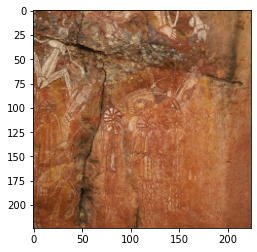

In [11]:
image_size = (224, 224)
img = load_image_file('data/test_images/IMG_6961.JPG')
img = resize(img, image_size, keep_aspect=False, crop=False)
print(model.predict(np.array([img])))
plt.imshow(img)